In [60]:
import numpy as np
from scipy import signal
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.pyplot import axvline, axhline
from collections import defaultdict

In [61]:
def zplane(z, p, filename=None):
    """Plot the complex z-plane given zeros and poles.
    """
    
    # get a figure/plot
    ax = plt.subplot(2, 2, 1)
    # TODO: should just inherit whatever subplot it's called in?

    # Add unit circle and zero axes    
    unit_circle = patches.Circle((0,0), radius=1, fill=False,
                                 color='black', ls='solid', alpha=0.1)
    ax.add_patch(unit_circle)
    axvline(0, color='0.7')
    axhline(0, color='0.7')
    
    # Plot the poles and set marker properties
    poles = plt.plot(p.real, p.imag, 'x', markersize=9, alpha=0.5)
    
    # Plot the zeros and set marker properties
    zeros = plt.plot(z.real, z.imag,  'o', markersize=9, 
             color='none', alpha=0.5,
             markeredgecolor=poles[0].get_color(), # same color as poles
             )

    # Scale axes to fit
    r = 1.5 * np.amax(np.concatenate((abs(z), abs(p), [1])))
    plt.axis('scaled')
    plt.axis([-r, r, -r, r])
#    ticks = [-1, -.5, .5, 1]
#    plt.xticks(ticks)
#    plt.yticks(ticks)

    """
    If there are multiple poles or zeros at the same point, put a 
    superscript next to them.
    TODO: can this be made to self-update when zoomed?
    """
    # Finding duplicates by same pixel coordinates (hacky for now):
    poles_xy = ax.transData.transform(np.vstack(poles[0].get_data()).T)
    zeros_xy = ax.transData.transform(np.vstack(zeros[0].get_data()).T)    

    # dict keys should be ints for matching, but coords should be floats for 
    # keeping location of text accurate while zooming

    # TODO make less hacky, reduce duplication of code
    d = defaultdict(int)
    coords = defaultdict(tuple)
    for xy in poles_xy:
        key = tuple(np.rint(xy).astype('int'))
        d[key] += 1
        coords[key] = xy
    for key, value in d.items():
        if value > 1:
            x, y = ax.transData.inverted().transform(coords[key])
            plt.text(x, y, 
                        r' ${}^{' + str(value) + '}$',
                        fontsize=13,
                        )

    d = defaultdict(int)
    coords = defaultdict(tuple)
    for xy in zeros_xy:
        key = tuple(np.rint(xy).astype('int'))
        d[key] += 1
        coords[key] = xy
    for key, value in d.items():
        if value > 1:
            x, y = ax.transData.inverted().transform(coords[key])
            plt.text(x, y, 
                        r' ${}^{' + str(value) + '}$',
                        fontsize=13,
                        )

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
        print ('Pole-zero plot saved to ' + str(filename))

def map_v(value, in_min, in_max, out_min, out_max):
    return (value - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

def fft_ECG(x3):
    Fs = 1000.0
    N=2**10 # 10 bits
    X3 = np.fft.fft(x3,N)
    X3 = X3[0:N//2]
    X3m = np.abs(X3)
    F = np.linspace(0,Fs/2,N//2)
    return F, 20*np.log10(X3m)

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

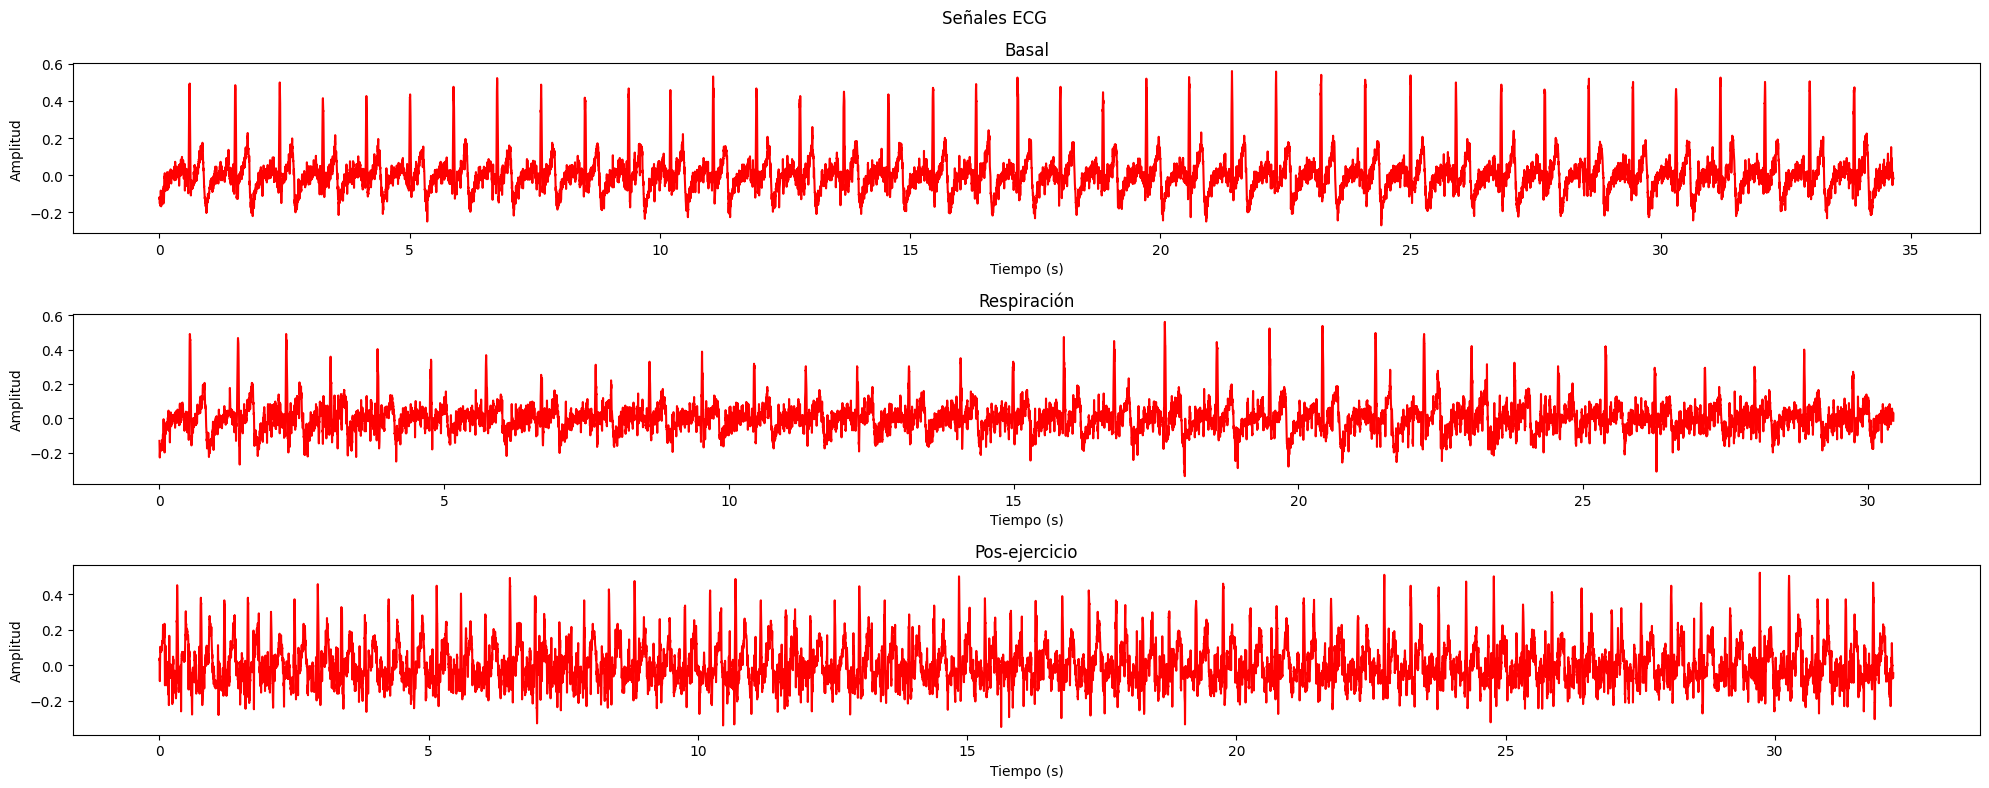

In [62]:
dataset = loadmat('Dataset.mat')
basal_full = dataset['Basal 1'].flatten()
basal_volts = map_v(basal_full, 0, 1023, -1.5, 1.5)
resp_full = dataset['Respiracion'].flatten()
resp_volts = map_v(resp_full, 0, 1023, -1.5, 1.5)
post_full = dataset['Post-ejercicio'].flatten()
post_volts = map_v(post_full, 0, 1023, -1.5, 1.5)

Fs=1000
Ts=1/Fs

# Tiempos de señal
tbasal =  np.arange(len(basal_volts))*Ts
tresp =  np.arange(len(resp_volts))*Ts
tpost =  np.arange(len(post_volts))*Ts

# Graficamos las señales
fig, axs=plt.subplots(3,1,figsize=(20,8))
plt.suptitle('Señales ECG')
axs[0].plot(tbasal,basal_volts, '-r'); axs[0].set(title = 'Basal', ylabel = 'Amplitud', xlabel = 'Tiempo (s)')
axs[1].plot(tresp,resp_volts, '-r'); axs[1].set(title = 'Respiración', ylabel = 'Amplitud', xlabel = 'Tiempo (s)')
axs[2].plot(tpost,post_volts, '-r'); axs[2].set(title = 'Pos-ejercicio', ylabel = 'Amplitud', xlabel = 'Tiempo (s)')
plt.tight_layout()
plt.show()
fig.savefig('Imagenes/Señales ECG completas.png')

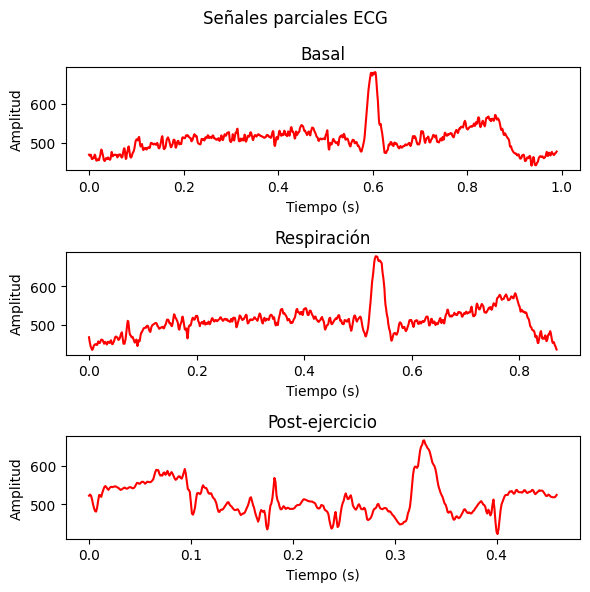

In [63]:
# Señal parcial

basal = dataset['Basal 1']
resp = dataset['Respiracion']
post = dataset['Post-ejercicio']

basal = basal[0]
resp = resp[0]
post = post[0]

B = len(basal); R = len(resp); P = len(post)
tbasal =  np.arange(B)*Ts
tresp =  np.arange(R)*Ts
tpost =  np.arange(P)*Ts

fig, axs=plt.subplots(3,1,figsize=(6,6))
plt.suptitle('Señales parciales ECG')
axs[0].plot(tbasal,basal, '-r'); axs[0].set(title = 'Basal', ylabel = 'Amplitud', xlabel = 'Tiempo (s)')
axs[1].plot(tresp,resp, '-r'); axs[1].set(title = 'Respiración', ylabel = 'Amplitud', xlabel = 'Tiempo (s)')
axs[2].plot(tpost,post, '-r'); axs[2].set(title = 'Post-ejercicio', ylabel = 'Amplitud', xlabel = 'Tiempo (s)')
plt.tight_layout()
plt.show()
fig.savefig('Imagenes/Señales parciales ECG.png')

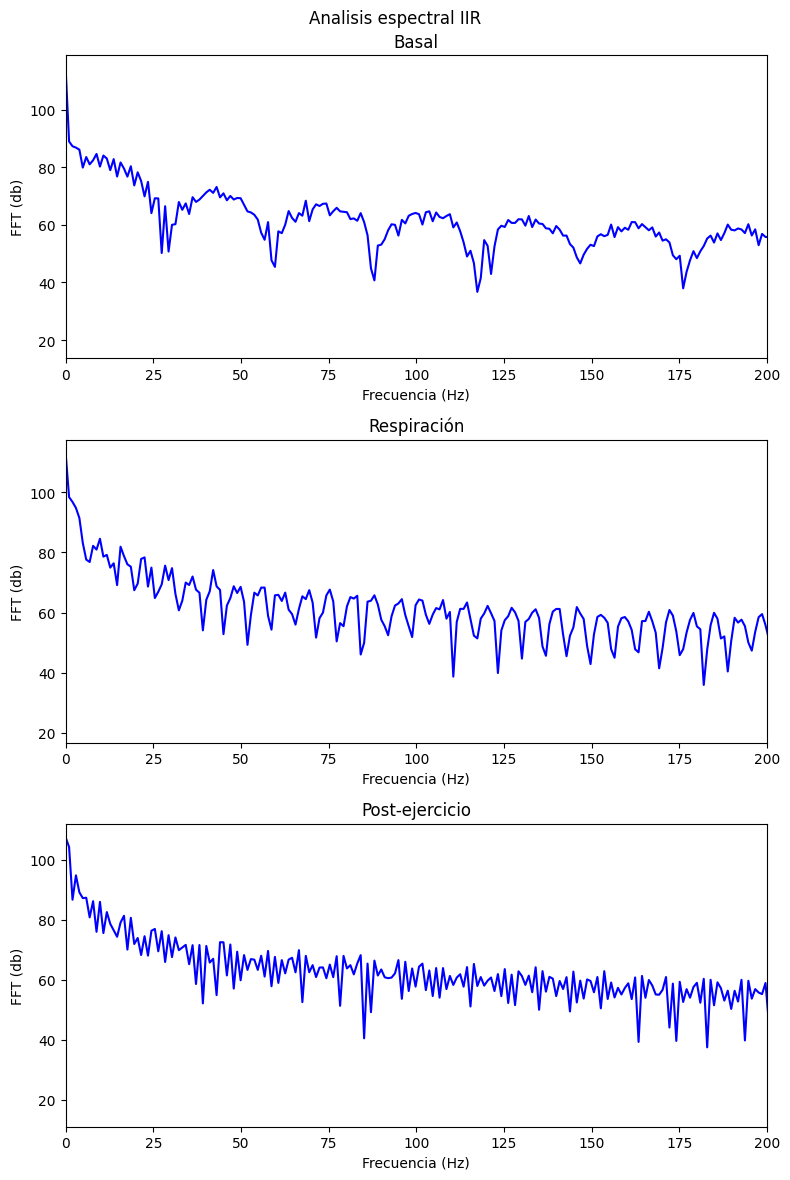

In [64]:
bx,by = fft_ECG(basal); rx,ry = fft_ECG(resp); px,py = fft_ECG(post)

fig, axs=plt.subplots(3,1,figsize=(8,12))
plt.suptitle('Analisis espectral IIR')
axs[0].plot(bx,by, 'b'); axs[0].set(title = 'Basal', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
axs[1].plot(rx,ry, 'b'); axs[1].set(title = 'Respiración', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
axs[2].plot(px,py, 'b'); axs[2].set(title = 'Post-ejercicio', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
plt.tight_layout()
plt.show()
fig.savefig('Imagenes/Analisis espectral IIR.png')

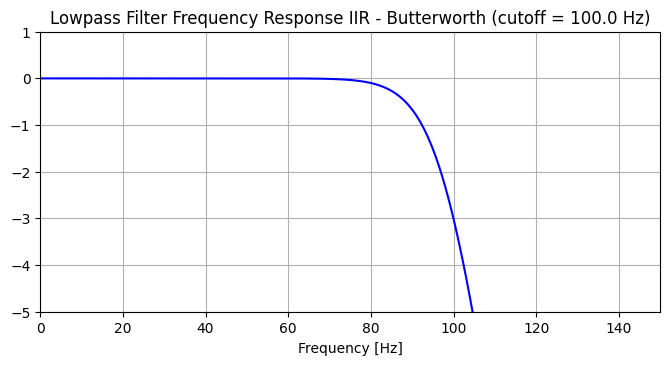

In [65]:
# Filtro IIR - Butterworth
order = 8
fs = 1000.0
cutoff = 100.0

b, a = butter_lowpass(cutoff, fs, order)

f = plt.figure(2, figsize = (8,8))
# Plotting the frequency response.
w, h = signal.freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)), 'b')
plt.title(f"Lowpass Filter Frequency Response IIR - Butterworth (cutoff = {cutoff} Hz)")
plt.xlabel('Frequency [Hz]')
plt.xlim(0,150)
plt.ylim(-5,1)
plt.grid()
fig.savefig('Imagenes/Lowpass Filter Frequency Response IIR - Butterworth.png')

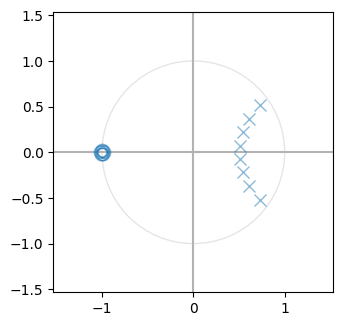

In [66]:
# Plano Z - IIR
z,p,k = signal.tf2zpk(b,a)
plt.figure(figsize = (8,8))
zplane(z,p)
plt.show()
fig.savefig('Imagenes/zplane butterworth IIR.png')

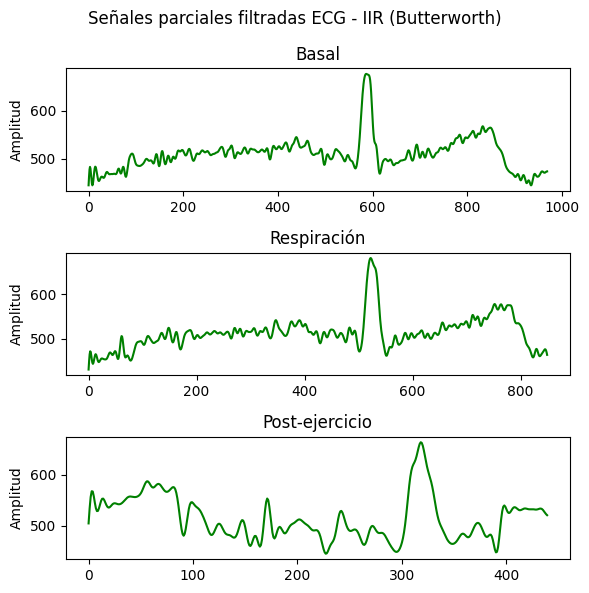

In [67]:
# Filtrando señales

basalIIR = butter_lowpass_filter(basal, cutoff, fs, order)
respIIR = butter_lowpass_filter(resp, cutoff, fs, order)
postIIR = butter_lowpass_filter(post, cutoff, fs, order)

fig, axs=plt.subplots(3,1,figsize=(6,6))
plt.suptitle('Señales parciales filtradas ECG - IIR (Butterworth)')
axs[0].plot(basalIIR[20:], 'g'); axs[0].set(title = 'Basal', ylabel = 'Amplitud')
axs[1].plot(respIIR[20:], 'g'); axs[1].set(title = 'Respiración', ylabel = 'Amplitud')
axs[2].plot(postIIR[20:], 'g'); axs[2].set(title = 'Post-ejercicio', ylabel = 'Amplitud')
plt.tight_layout()
plt.show()
fig.savefig('Imagenes/Señales parciales filtradas ECG - IIR (Butterworth).png')

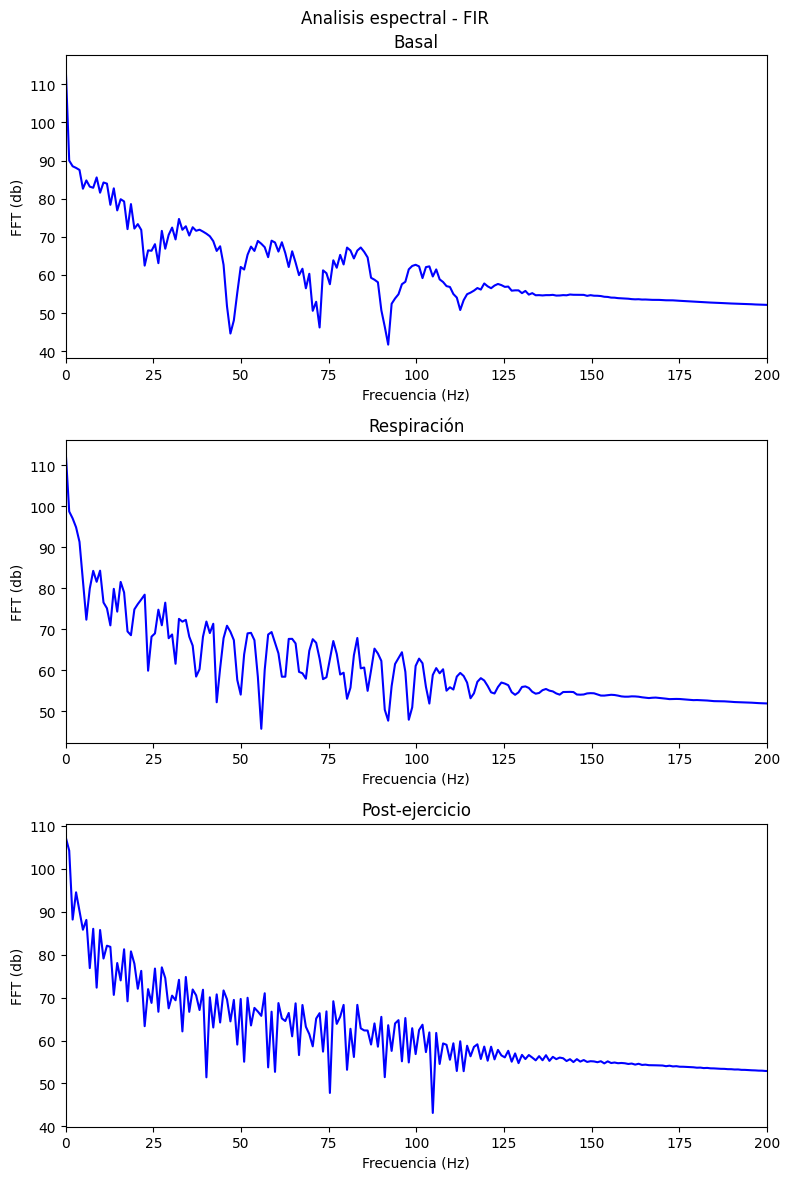

In [68]:
bx,by = fft_ECG(basalIIR); rx,ry = fft_ECG(respIIR); px,py = fft_ECG(postIIR)
fig, axs=plt.subplots(3,1,figsize=(8,12))
plt.suptitle('Analisis espectral - FIR')
axs[0].plot(bx,by, 'b'); axs[0].set(title = 'Basal', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
axs[1].plot(rx,ry, 'b'); axs[1].set(title = 'Respiración', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
axs[2].plot(px,py, 'b'); axs[2].set(title = 'Post-ejercicio', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
plt.tight_layout()
plt.show()
fig.savefig('Imagenes/Analisis espectral - FIR.png')

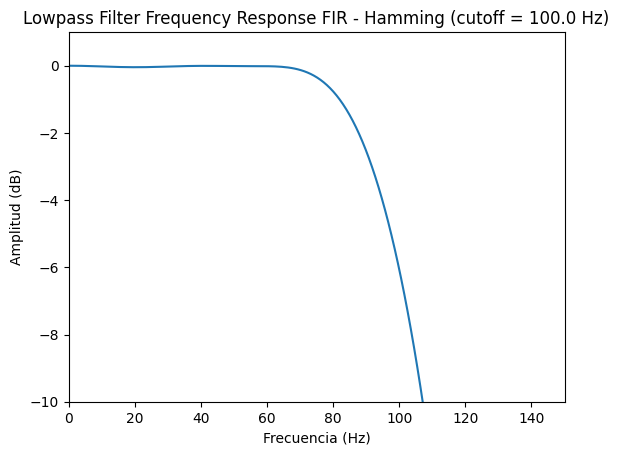

In [69]:
# FIR filter
fc = 100.0
M = 50 # orden del filtro
FIRfilter = signal.firwin(M, fc, window='hamming',fs=Fs)
w, h = signal.freqz(FIRfilter, 1)
freq = w / (2 * np.pi) * Fs
amp = 20 * np.log10(np.abs(h))

#Ploateamos
plt.plot(freq, amp)
plt.title(f"Lowpass Filter Frequency Response FIR - Hamming (cutoff = {cutoff} Hz)")
plt.xlim(0,150)
plt.ylim(-10,1)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.show()
fig.savefig('Imagenes/Lowpass Filter Frequency Response FIR - Hamming.png')

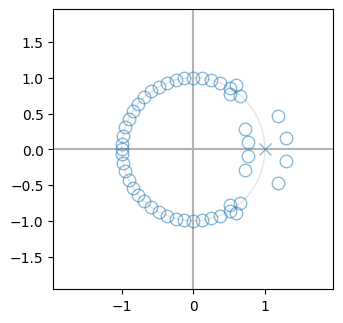

In [70]:
# Plano Z - FIR
plt.figure(figsize = (8,8))
zplane(np.roots(FIRfilter), np.array([1]))
plt.show()
fig.savefig('Imagenes/Lowpass Filter Frequency Response FIR - Hamming.png')

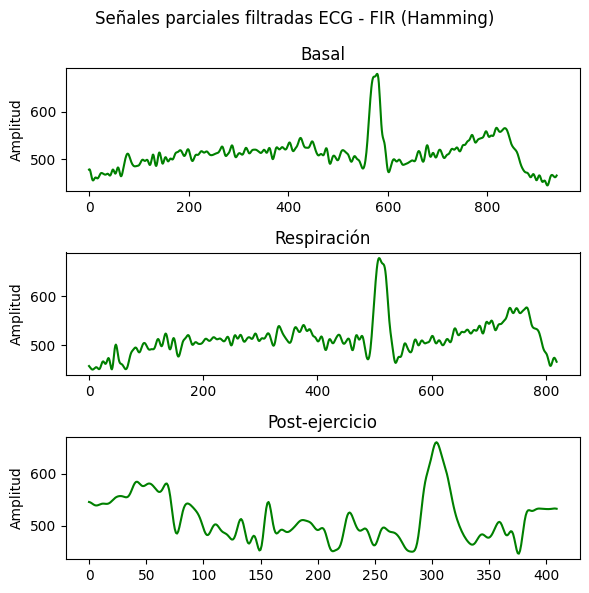

In [71]:
basalFIR = signal.lfilter(FIRfilter, 1, basal)
respFIR = signal.lfilter(FIRfilter, 1, resp)
postFIR = signal.lfilter(FIRfilter, 1, post)

fig, axs=plt.subplots(3,1,figsize=(6,6))
plt.suptitle('Señales parciales filtradas ECG - FIR (Hamming)')
axs[0].plot(basalFIR[50:], 'g'); axs[0].set(title = 'Basal', ylabel = 'Amplitud')
axs[1].plot(respFIR[50:], 'g'); axs[1].set(title = 'Respiración', ylabel = 'Amplitud')
axs[2].plot(postFIR[50:], 'g'); axs[2].set(title = 'Post-ejercicio', ylabel = 'Amplitud')
plt.tight_layout()
plt.show()
fig.savefig('Imagenes/Señales parciales filtradas ECG - FIR (Hamming).png')

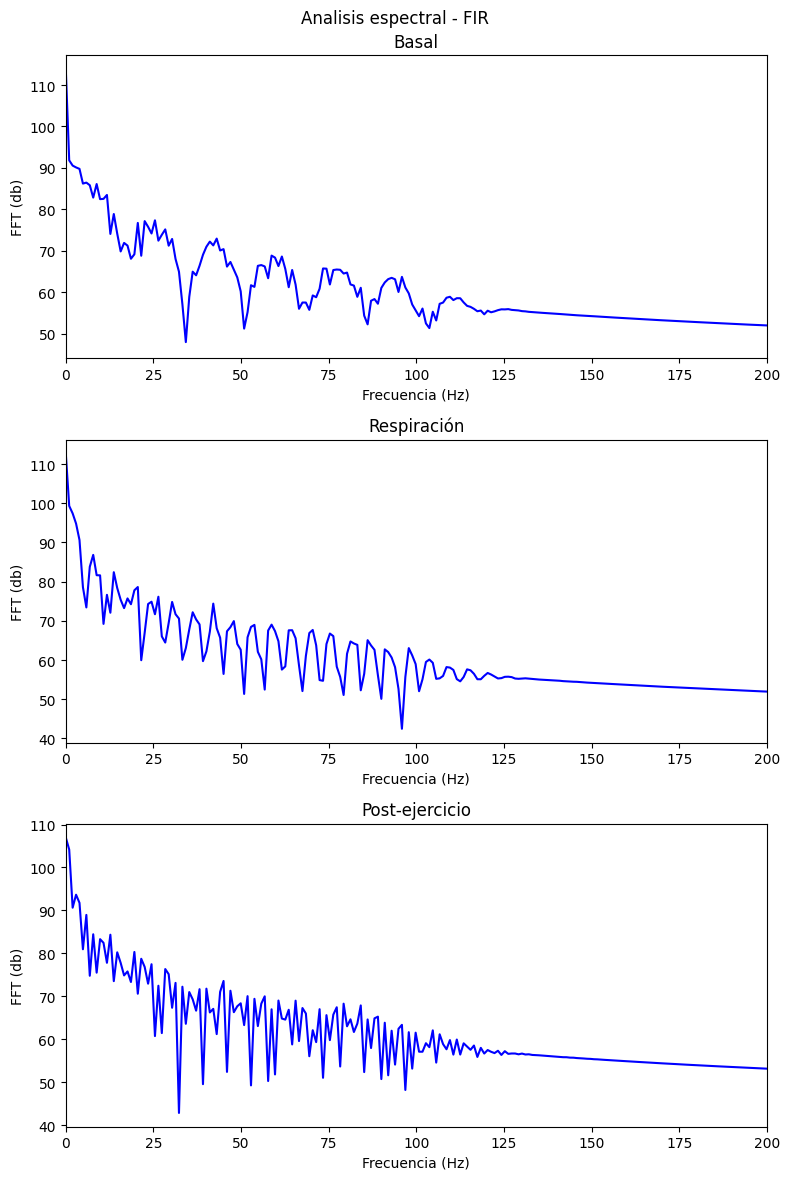

In [72]:
bx,by = fft_ECG(basalFIR); rx,ry = fft_ECG(respFIR); px,py = fft_ECG(postFIR)
fig, axs=plt.subplots(3,1,figsize=(8,12))
plt.suptitle('Analisis espectral - FIR')
axs[0].plot(bx,by, 'b'); axs[0].set(title = 'Basal', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
axs[1].plot(rx,ry, 'b'); axs[1].set(title = 'Respiración', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
axs[2].plot(px,py, 'b'); axs[2].set(title = 'Post-ejercicio', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
plt.tight_layout()
plt.show()
fig.savefig('Imagenes/Analisis espectral - FIR.png')